# Data Cleaning, a bit of Feature Engineering & Vectorization

In [308]:
import pandas as pd
import numpy as np
import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Automating the import
Getting the data into the notebook should be as easy as possible. With some looping and variable assignment I get my 4 `.csv` files imported and put into PANDAS DataFrames quickly.

In [113]:
subreddit = 'Sandersforpresident'
pds = []
years = ('2016','2020')
d_types = ('comment','submission')
for year in years:
    for d_type in d_types:
            pds.append(pd.read_csv(f'datasets/{subreddit}_{d_type}_{year}.csv'))

for i in pds:
    #i.set_index('id', inplace=True)
    i.dropna(axis=0, subset=['created_utc','score'], inplace=True)
    for idx,date in enumerate(i[['id','created_utc']].values):
        try:
            int(date[1])
        except:
            print(i.iloc[idx])
            
    i['created_utc'] = [datetime.datetime.fromtimestamp(int(date)) for date in i['created_utc']]
df_comment_2016, df_submission_2016, df_comment_2020, df_submission_2020 = pds

## Comment & Post metadata/engineering
When I combine the DataFrames of comments and posts for each time period I think that there may be something about the quality of posts vs comments and/or other interesting bits that may come in handy so I'm creating a One Hot feature `is_comment` to denote whether or not the text comes from a comment. Additionally, I am combing the submission title and body text into one feature and calling it `body` similar to the comments.

In [114]:
com_dfs = [df_comment_2016, df_comment_2020]
for df in com_dfs:
    df['is_comment'] = 1

In [115]:
sub_dfs = [df_submission_2016, df_submission_2020]
for df in sub_dfs:
    df['is_comment'] = 0
    df.fillna({'selftext':''}, inplace=True)
    df['body'] = df['title'] + ' ' + df['selftext'] + ' ' + df['author']

## Combining DataFrames
The DataFrames combining the Comments and Submissions is done for each year via concatanation. Then I drop some vestigal columns and check for duplicates again.

In [116]:
def namestr(obj, namespace): # https://stackoverflow.com/a/592891
    return [name for name in namespace if namespace[name] is obj]

df_2016 = pd.concat([df_comment_2016, df_submission_2016], sort=False)
df_2020 = pd.concat([df_comment_2020, df_submission_2020], sort=False)

for df in (df_2016, df_2020):
    df.drop(columns=['title','selftext'], inplace=True)
    df.drop_duplicates(subset='id',keep='first',inplace=True)
    
    fname = f'datasets/{namestr(df, globals())[1]}.csv'
    print(fname)
    try:
        df_old = pd.read_csv(fname)
        df = pd.concat([df_old, df])
        df.drop_duplicates(subset='id',keep='first',inplace=True)
    except:
        pass
    
    df.to_csv(fname, index=False)
    print(f'{df.shape[0]} rows of data.')


datasets/df_2016.csv
258997 rows of data.
datasets/df_2020.csv
48651 rows of data.


## Label Data & Combine DataFrames 

In [117]:
df_2016 = pd.read_csv('datasets/df_2016.csv')
df_2020 = pd.read_csv('datasets/df_2020.csv')

df_2016['is_2016'] = 1
df_2020['is_2016'] = 0

df = pd.concat([df_2016,df_2020])
df.dropna(axis=0,subset = ['score'] , inplace=True)
#drop vestigal columns that I may want later...
df.dropna(axis=0, subset=['body'], inplace=True)
df.drop(columns=['id','num_comments','stickied','parent_id','author'] , inplace=True)

## Feature Engineering
I have intuition that:
- Average post length will change between the two years.
- Average word length used will change over time
- There will be "louder" discourse in 2020. I will check for ALL CAPS and !
- Vader Sentiment using the Vader analyzer
- Vader * Score. This indicates the boost that sentiment gets in score from the subreddit.
- Various date columns

In [118]:
def avg_word_len(x):
    return(np.mean([len(word) for word in x.split()]))
def post_len(x):
    return(len([post for post in x.split()]))
def get_loud(x):
    count = 0
    for word in x.split():
        if word.isupper():
            count+=1
    count += x.count("!")
    return(count)

df['avg_word_len'] = df['body'].map(avg_word_len)
df['post_len'] = df['body'].map(post_len)
df['loud_shouting'] = df['body'].map(get_loud)
df.sample(3)

,created_utc,body,score,is_comment,is_2016,avg_word_len,post_len,loud_shouting
17642,2015-05-07 08:36:49,[Too late.](http://www.reddit.com/r/SandersFor...,2.0,1,1,39.666667,3,0
215381,2016-04-20 12:22:04,"How did that NY Primary feel, berniebots? [rem...",0.0,0,1,5.888889,9,1
144050,2016-02-19 19:48:40,BERNIE SANDERS SPOKEN WORD POEM onemigs,10.0,0,1,5.666667,6,5


In [125]:
analyzer = SentimentIntensityAnalyzer()
## https://github.com/cjhutto/vaderSentiment
df['vaderSentiment'] = df['body'].map(lambda x: analyzer.polarity_scores(x)['compound'])

In [126]:
df['senti_score'] = df['vaderSentiment'] * df['score']

In [127]:
df['created_utc_dt'] = pd.to_datetime(df['created_utc'])

df['year'] = [date.year for date in df.loc[:,'created_utc_dt']]
df['weekofyear'] = [date.weekofyear for date in df.loc[:,'created_utc_dt']]
df['month'] = [date.month for date in df['created_utc_dt']]
df.loc[df['year'] == 2016, 'month'] = df.loc[df['year'] == 2016,'month'] + 12
df.loc[df['year'] == 2016, 'weekofyear'] = df.loc[df['year'] == 2016,'weekofyear'] + 52

,created_utc,body,score,is_comment,is_2016,avg_word_len,post_len,loud_shouting,vaderSentiment,senti_score
232373,2016-05-19 21:42:31,To HRC and her supporters: You're not entitled...,1.0,0,1,4.666667,21,1,-0.7584,-0.7584
67031,2015-10-10 10:31:40,"I'm subscribed to /r/SandersForPresident, yet ...",1.0,0,1,5.000000,27,1,0.0000,0.0000
28723,2015-06-13 10:43:18,Susan Sarandon is feeling Bernie [deleted],3.0,0,1,6.166667,6,0,0.1280,0.3840
117503,2016-02-01 20:12:50,Donated! [removed] ITSecGeek,10.0,0,1,8.666667,3,1,0.0000,0.0000
21410,2015-05-11 10:37:01,"Planning to register as a Democrat, then vote....",6.0,1,1,5.090909,11,0,0.0000,0.0000
33153,2019-07-06 16:23:16,“Liberal media” slanders Medicare for all and ...,112.0,0,0,5.210526,19,0,0.0000,0.0000
94088,2016-01-06 18:29:11,Field The Bern- Android? Is Field The Bern ava...,8.0,0,1,4.736842,19,0,0.0000,0.0000
216393,2016-04-21 11:01:59,"It's 2PM EST. Please hop on the dialer Yes, Ne...",51.0,0,1,4.818182,77,2,-0.8336,-42.5136
99266,2016-01-15 14:42:35,"Sunday on 'ABC This Week': Donald Trump, Hilla...",34.0,0,1,5.214286,14,1,0.0000,0.0000
202948,2016-04-08 17:46:04,The real-life Gordon Gekko on why he feels the...,105.0,0,1,4.545455,11,0,0.0000,0.0000


In [509]:
df = df[~df.duplicated(subset='body', keep='first')]
df.to_csv('datasets/data.csv', index=False)
print(f'{df.shape[0]} rows of data!')

302203 rows of data!


In [511]:
df[df['is_comment'] == 0].to_csv('datasets/data_submissions.csv', index=False)
print(f'{df[df["is_comment"] == 0].shape[0]} rows of data!')

260377 rows of data!


## Generate Graphs for Presentation

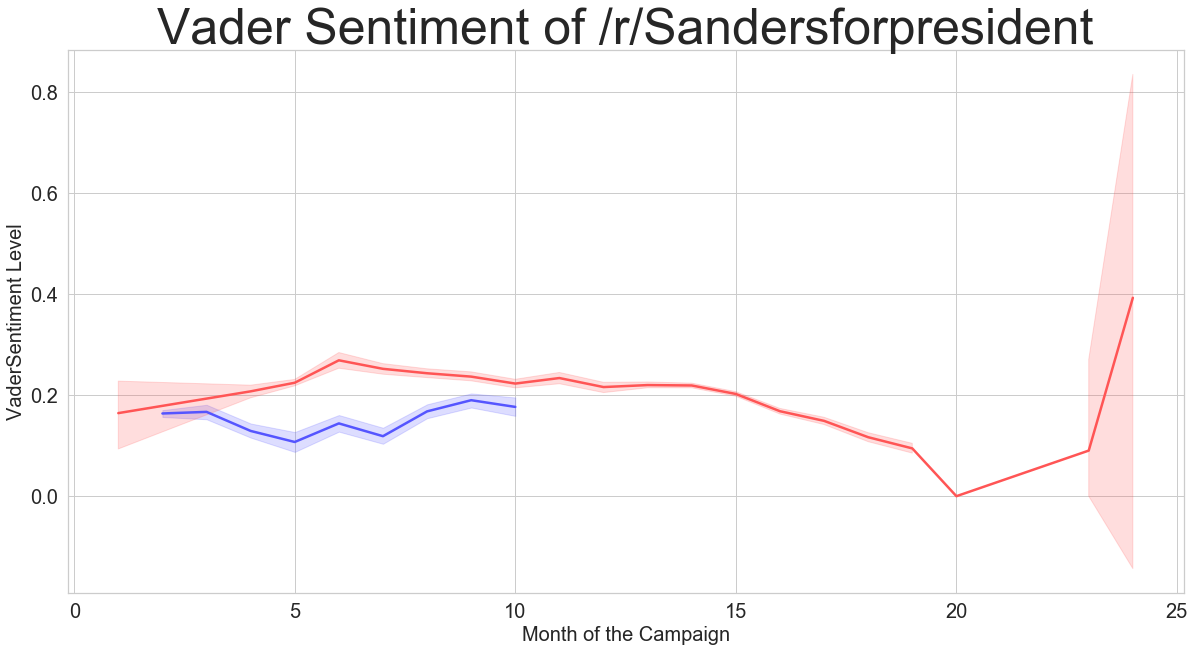

In [502]:
sns.set(style="whitegrid")

plt.figure(figsize = (20,10))
plot = sns.lineplot(x='month',
                    y='vaderSentiment',
                    hue='is_2016',
                    data=df,
                   linewidth=2.5,
                palette="seismic",
                   legend=False);
plot.axes.set_title("Vader Sentiment of /r/Sandersforpresident",fontsize=50)
plot.set_xlabel("Month of the Campaign",fontsize=20)
plot.set_ylabel("VaderSentiment Level",fontsize=20)
plot.tick_params(labelsize=20)

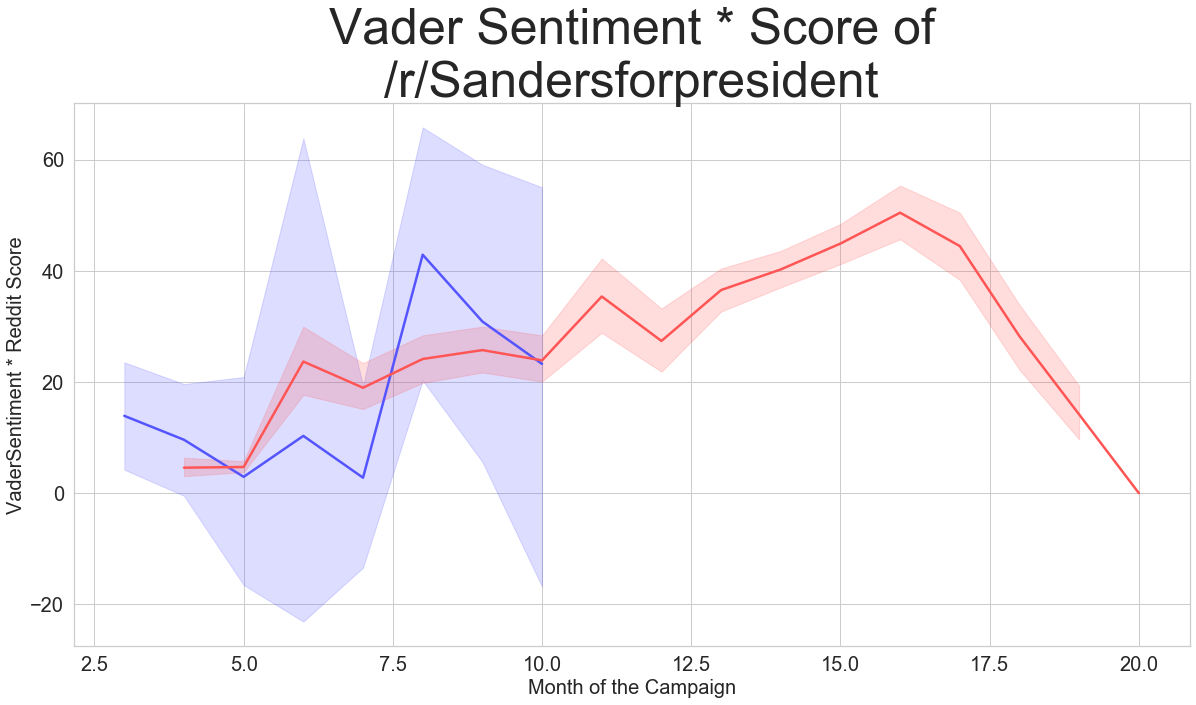

In [508]:
sns.set(style="whitegrid")

plt.figure(figsize = (20,10))
plot = sns.lineplot(x='month',
                    y='senti_score',
                    hue='is_2016',
                    data=df[(df['month'] < 23) & (df['month'] > 2)],
                   linewidth=2.5,
                palette="seismic",
                   legend=False);
plot.axes.set_title("Vader Sentiment * Score of\n/r/Sandersforpresident",fontsize=50)
plot.set_xlabel("Month of the Campaign",fontsize=20)
plot.set_ylabel("VaderSentiment * Reddit Score",fontsize=20)
plot.tick_params(labelsize=20)